# จัดกระทำข้อมูลเบื้องต้น และสำรวจข้อมูล
INPUT : 
   - movies_metadata.csv
   - keywords.csv
   - credits.csv
OUTPUT :
   - cleaned_6610401993.csv
   - cleaned_6610401993.pkl
คำอธิบาย
   - column output เพิ่มเติม
       'genres' : ระบุประเภทหนังใน list เช่น ["Adventure","Comedy"]
       'collection_name' : ระบุชื่อ series หนัง
       'collection_count' : ระบุจำนวนหนังใน series เดียวกัน
       'main_cast_gender' : ระบุเพศนักแสดงหลัก
       'main_cast_character' : ระบุชื่อตัวละครหลัก
       'main_cast_name' : ระบุชื่อตัวระครหลัก
       'movie_after' : จำนวนภาคต่อจากหนังเรื่องนี่
       'roi' : ระบุ return of investment = revenue / budget
       'keywords' : ระบุ keyword ในหนัง
       'vote_after' : ระบุ คะแนน ในภาคถัดไป
       'next_main_cast_gender_same' : ภาคต่อไปตัวละครเพศเดียวกันไหม
       'next_main_cast_actor_name_same' : ภาคต่อไปนักแสดงคนเดียวกันไหม
       'next_main_cast_same' : ภาคต่อไปตัวละครตัวเดียวกันไหม
       'vote_increase' : มีการเพิ่มของโหวดเท่าไรในภาคถึดไป = (โหวดภาคต่อไป/โหวดภาคนี้) - 1

# Clean Data

### Import Dependencies

In [846]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
from sklearn.utils import shuffle
from scipy import stats
import kagglehub
import seaborn as sns

### set randomseed to be deterministic

In [847]:
# Define seed


### set path

In [848]:
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sunmodza\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7


In [849]:
!ls C:\Users\sunmodza\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [850]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable


In [851]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# โหลดข้อมูล

## โหลดข้อมูลโดยรวมของหนัง (ส่วนใหญ่ข้อมูลที่วิเคราะห์จะอยู่ในนี้)

In [852]:
df = pd.read_csv(path+"\movies_metadata.csv")

C:\Users\sunmodza\AppData\Local\Temp\ipykernel_64168\3710841025.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+"\movies_metadata.csv")


## โหลดข้อมูล keyword ของหนัง

In [853]:
df_keyword = pd.read_csv(path+"\keywords.csv")

## โหลดข้อมูล นักแสดง และผู้อยู่เบื้องหลังของหนัง

In [854]:
df_credit = pd.read_csv(path+"\credits.csv")

# สำรวจข้อมูลเบื้องต้น

## 1. DataFrame หลัก

<p>
ชุดข้อมูลนี้ประกอบด้วยข้อมูลเกี่ยวกับภาพยนตร์ทั้งหมด <b>24 คอลัมน์</b> และ <b>45,466 แถว</b> แต่ละคอลัมน์มีความหมายดังนี้:
</p>

<ul>
    <li>
        <b>adult</b>: (บูลีน) ระบุว่าภาพยนตร์เรื่องนี้มีเนื้อหาสำหรับผู้ใหญ่หรือไม่
        <ul>
            <li><code>False</code>: ไม่ใช่ภาพยนตร์สำหรับผู้ใหญ่</li>
            <li><code>True</code>: เป็นภาพยนตร์สำหรับผู้ใหญ่</li>
        </ul>
    </li>
    <li>
        <b>belongs_to_collection</b>: (พจนานุกรมซ้อนพจนานุกรม) ข้อมูลเกี่ยวกับชุดภาพยนตร์ (แฟรนไชส์) ที่ภาพยนตร์เรื่องนี้เป็นส่วนหนึ่ง หากไม่มี จะเป็นค่าว่าง (NaN หรือ Null)
        <br>
        ตัวอย่างสำหรับ "Toy Story":
        <pre><code>
{
  "id": 10194,
  "name": "Toy Story Collection",
  "poster_path": "/7G9915LfFDa1meEPejOOtF/YVq46h.jpg",
  "backdrop_path": "/9FBwqcdajxgiiD1IrOkNHucRTLq.jpg"
}
        </code></pre>
    </li>
    <li>
        <b>budget</b>: (จำนวนเต็ม) งบประมาณที่ใช้ในการสร้างภาพยนตร์ (ดอลลาร์สหรัฐ)
        <br>
        ตัวอย่าง: <code>30000000</code>
    </li>
    <li>
        <b>genres</b>: (รายชื่อพจนานุกรม) ประเภท (แนว) ของภาพยนตร์แต่ละประเภท โดยแต่ละประเภทจะมี ID และชื่อ
        <br>
        ตัวอย่างสำหรับ "Toy Story":
        <pre><code>
[
  {"id": 16, "name": "Animation"},
  {"id": 35, "name": "Comedy"},
  {"id": 10751, "name": "Family"}
]
        </code></pre>
    </li>
    <li>
        <b>homepage</b>: (URL) เว็บไซต์อย่างเป็นทางการของภาพยนตร์ หากไม่มี จะเป็นค่าว่าง (NaN หรือ Null)
        <br>
        ตัวอย่าง: <code>http://toystory.disney.com/toy-story</code>
    </li>
    <li>
        <b>id</b>: (จำนวนเต็ม) รหัสเฉพาะของภาพยนตร์ในฐานข้อมูล
    </li>
    <li>
        <b>imdb_id</b>: (สตริง) รหัสเฉพาะของภาพยนตร์ในฐานข้อมูล IMDb
        <br>
        ตัวอย่าง: <code>tt0114709</code>
    </li>
    <li>
        <b>original_language</b>: (สตริง) รหัสภาษา ISO 639-1 ของภาษาต้นฉบับ
        <br>
        ตัวอย่าง: <code>'en'</code> (ภาษาอังกฤษ)
    </li>
    <li>
        <b>original_title</b>: (สตริง) ชื่อดั้งเดิมของภาพยนตร์ (โดยทั่วไปเป็นชื่อในภาษาต้นฉบับ)
        <br>
        ตัวอย่าง: <code>"Toy Story"</code>
    </li>
    <li>
        <b>overview</b>: (สตริง) บทสรุปย่อของภาพยนตร์
    </li>
    <li>
        <b>popularity</b>: (ทศนิยม) ค่าความนิยมของภาพยนตร์
    </li>
    <li>
        <b>poster_path</b>: (สตริง) เส้นทางไปยังรูปภาพโปสเตอร์ของภาพยนตร์
    </li>
    <li>
        <b>production_companies</b>: (รายชื่อพจนานุกรม) บริษัทที่เกี่ยวข้องกับการผลิตภาพยนตร์ โดยแต่ละบริษัทจะมีชื่อและ ID
        <br>
        ตัวอย่าง:
        <pre><code>
[
  {"name": "Pixar Animation Studios", "id": 3}
]
        </code></pre>
    </li>
    <li>
        <b>production_countries</b>: (รายชื่อพจนานุกรม) ประเทศที่ผลิตภาพยนตร์ โดยแต่ละประเทศจะมีรหัส ISO 3166-1 และชื่อ
        <br>
        ตัวอย่าง:
        <pre><code>
[
  {"iso_3166_1": "US", "name": "United States of America"}
]
        </code></pre>
    </li>
    <li>
        <b>release_date</b>: (วันที่) วันที่เข้าฉายของภาพยนตร์
    </li>
    <li>
        <b>revenue</b>: (ทศนิยม) รายได้รวมของภาพยนตร์ทั่วโลก (ดอลลาร์สหรัฐ)
        <br>
        ตัวอย่าง: <code>373554033.0</code>
    </li>
    <li>
        <b>runtime</b>: (ทศนิยม) ระยะเวลาฉายของภาพยนตร์ (นาที)
        <br>
        ตัวอย่าง: <code>81.0</code>
    </li>
    <li>
        <b>spoken_languages</b>: (รายชื่อพจนานุกรม) ภาษาที่ใช้พูดในภาพยนตร์ โดยแต่ละภาษาจะมีรหัส ISO 639-1 และชื่อ
        <br>
        ตัวอย่าง:
        <pre><code>
[
  {"iso_639_1": "en", "name": "English"}
]
        </code></pre>
    </li>
    <li>
        <b>status</b>: (สตริง) สถานะปัจจุบันของภาพยนตร์ เช่น "Released", "In Production"
    </li>
    <li>
        <b>tagline</b>: (สตริง) สโลแกนของภาพยนตร์ หากไม่มี จะเป็นค่าว่าง (NaN หรือ Null)
        <br>
        ตัวอย่าง: <code>NaN</code>
    </li>
    <li>
        <b>title</b>: (สตริง) ชื่อเรื่องของภาพยนตร์ (อาจแตกต่างจาก <code>original_title</code> หากมีการแปล)
        <br>
        ตัวอย่าง: <code>"Toy Story"</code>
    </li>
    <li>
        <b>video</b>: (บูลีน) ระบุว่ามีวิดีโอตัวอย่าง (trailer) หรือไม่
        <ul>
            <li><code>False</code>: ไม่มีวิดีโอตัวอย่าง</li>
            <li><code>True</code>: มีวิดีโอตัวอย่าง</li>
        </ul>
    </li>
    <li>
        <b>vote_average</b>: (ทศนิยม) คะแนนเฉลี่ยที่ผู้ชมโหวตให้กับภาพยนตร์ (0 ถึง 10)
    </li>
    <li>
        <b>vote_count</b>: (ทศนิยม) จำนวนครั้งที่ผู้ชมโหวตให้กับภาพยนตร์
    </li>
</ul>

In [855]:
df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [856]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [857]:
df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [858]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

## Keyword DF

เก็บข้อมูล keyword ของแต่ละ Movie โดย id สามารถเชื่อมโยงกับ Main DataFrame ได้
- keywords : เก็บทุก keyword ของแต่ละ movie โดยสามารถมีหลาย keyword ได้ ภายในแต่ละ keyword มี id ของ keyword นั้น กับ name หรือชื่อ

In [859]:
df_keyword.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [860]:
df_keyword.columns

Index(['id', 'keywords'], dtype='object')

In [861]:
df_keyword.describe()

,id
count,46419.000000
mean,109769.951873
std,113045.780256
min,2.000000
25%,26810.500000
50%,61198.000000
75%,159908.500000
max,469172.000000


In [862]:
df_keyword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


## 3. Credit DataFrame

เก็บข้อมูลของนักแสดงและผู้อยู่เบื้องหลังของแต่ละ Movie โดย id สามารถเชื่อมโยงกับ Main DataFrame ได้
- cast : นักแสดงหลักประกอบด้วยหลายอันใน 1 cell แต่ละอันมีค่าดังตัวอย่างดังนี้
    {'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}
    - cast_id : id นักแสดง
    - character : ชื่อตัวละครที่แสดง
    - credit_id : id ของ entity
    - gender : เพศของนักแสดง
    - name : ชื่อของนักแสดง
    - order : เลขน้อยคือตัวละครหลัก (เริ่มจาก 0)
    - profile_path : โยงไปยังที่เก็บรูป (ไม่ได้ใช้)

In [863]:
df_credit.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [864]:
df_credit["cast"].iloc[0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

# Data Preparing & Cleaning

## Missing Data ใน DataFrame หลัก

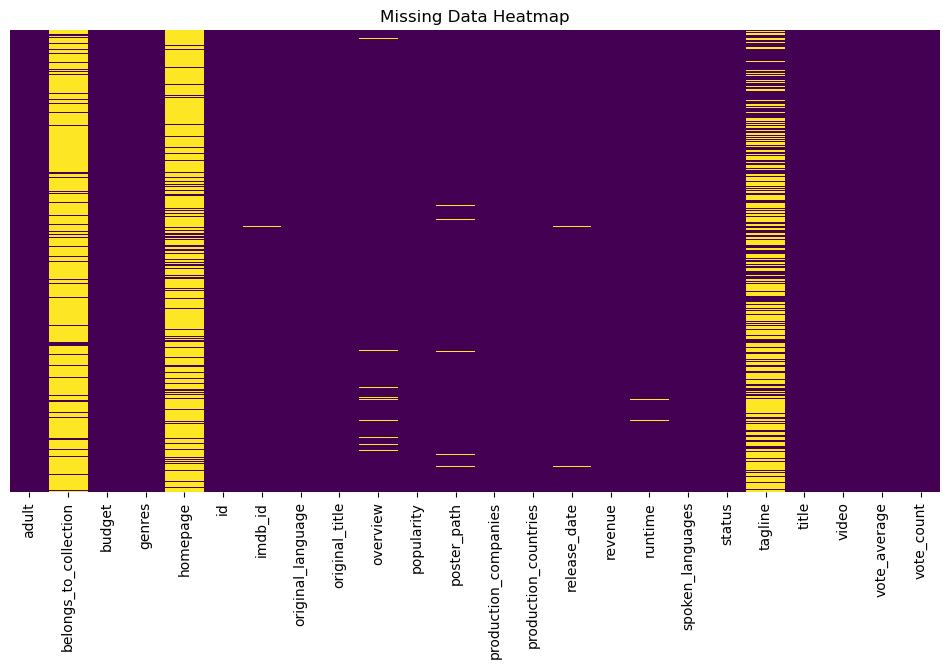

In [865]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [866]:
df.isnull().sum().rename("missing_values")

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
Name: missing_values, dtype: int64

In [867]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [868]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45466 non-null  object        
 1   belongs_to_collection  4494 non-null   object        
 2   budget                 45466 non-null  object        
 3   genres                 45466 non-null  object        
 4   homepage               7782 non-null   object        
 5   id                     45466 non-null  object        
 6   imdb_id                45449 non-null  object        
 7   original_language      45455 non-null  object        
 8   original_title         45466 non-null  object        
 9   overview               44512 non-null  object        
 10  popularity             45461 non-null  object        
 11  poster_path            45080 non-null  object        
 12  production_companies   45463 non-null  object        
 13  p

### ปรับแก้ประเภทตัวแปรเป็น numeric

In [869]:
df = df[pd.to_numeric(df['budget'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['popularity'], errors='coerce').notnull()]
df['budget'] = df['budget'].astype(float)
df['popularity'] = df['popularity'].astype(float)

### deduplication id

In [870]:
df = df.drop_duplicates(subset=['id'])

# สร้างชุดข้อมูลเพิ่มเติม หรือทำการนำ Repeating Group ออกมา

### สร้าง dataframe ที่แสดงข้อมูล collection ต่างๆที่มีใน movie
 - collection คือ movie ที่เป็น set เดียวกัน

In [871]:
collect = []
for v in df.iterrows():
    v = v[1]
    try:
        bc = eval(str(v["belongs_to_collection"]))
        bc["movie_id"] = v["id"]
        bc.pop("id")
        bc.pop("poster_path")
        bc.pop("backdrop_path")
    except Exception as e:
        bc = {}
        continue
    collect.append(bc)

In [872]:
collect_df = pd.DataFrame(collect)

### สร้าง Feature จำนวนหนังใน Collection เดัยวกับ และจำนวนหนังก่อนเรื่องนี้ เพื่อนำไปใช้ต่อ

In [873]:
# find how many number of movie sequal that come before them
# Count how many movies are in each collection
collection_counts = collect_df['name'].value_counts().reset_index()
collection_counts.columns = ['collection_name', 'movie_count']

# Display collections with more than one movie (sequels)
sequels_df = collection_counts[collection_counts['movie_count'] > 1]
print(f"There are {len(sequels_df)} movie collections with sequels")

# For each movie, find how many movies in its collection came before it
# First, merge release dates from main dataframe
collect_with_dates = collect_df.merge(df[['id', 'release_date']], 
                                     left_on='movie_id', 
                                     right_on='id', 
                                     how='left')

# Group by collection name and count movies released before each movie
movies_before = []
for name, group in collect_with_dates.groupby('name'):
    # Convert release_date to datetime
    group['release_date'] = pd.to_datetime(group['release_date'], errors='coerce')
    # Sort by release date
    group = group.sort_values('release_date')
    
    # For each movie in the collection, count how many came before it
    for i, row in enumerate(group.itertuples()):
        movies_before.append({
            'movie_id': row.movie_id,
            'collection_name': name,
            'movies_before': i,  # Index in sorted group = number of movies before
            'release_date': row.release_date
        })

# Create dataframe with results
sequels_count_df = pd.DataFrame(movies_before)
# drop release date
sequels_count_df.drop(columns=['release_date'], inplace=True)
sequels_count_df.head(10)

# add same collection count to all movie with collection
sequels_count_df["collection_count"] = sequels_count_df.groupby("collection_name")["movie_id"].transform("count")
sequels_count_df.head(10)


There are 1305 movie collections with sequels


,movie_id,collection_name,movies_before,collection_count
0,117263,... Has Fallen Collection,0,2
1,267860,... Has Fallen Collection,1,2
2,1652,00 Schneider Filmreihe,0,1
3,19430,08/15 Collection,0,1
4,10035,100 Girls Collection,0,2
5,20648,100 Girls Collection,1,2
6,12230,101 Dalmatians (Animated) Collection,0,2
7,13654,101 Dalmatians (Animated) Collection,1,2
8,11674,101 Dalmatians (Live-Action) Collection,0,2
9,10481,101 Dalmatians (Live-Action) Collection,1,2


In [874]:
df = df.drop(columns=["belongs_to_collection"])

### สร้าง DataFrame ของประเภทหนัง โดยลบ repeating group เพื่อนำไปใช้ในขั้นตอนต้อๆไป

In [875]:
genres_data = []
for v in df.iterrows():
    v = v[1]
    genre = eval(v["genres"])
    for item in genre:
        item["movie_id"] = v["id"]
        item.pop("id")
        genres_data.append(item)
df_genre = pd.DataFrame(genres_data)

In [876]:
df_genre.head(5)

,name,movie_id
0,Animation,862
1,Comedy,862
2,Family,862
3,Adventure,8844
4,Fantasy,8844


### สร้าง DataFrame ของ production companies ที่เกี่ยวข้องกับหนังแต่ละเรื่อง โดยลบ repeating group เพื่อนำไปใช้ในขั้นตอนต้อๆไป

In [877]:
prod_comp = []
for v in df.iterrows():
    v = v[1]
    try:
        bc = eval(str(v["production_companies"]))
        for item in bc:
            item["movie_id"] = v["id"]
            item.pop("id")
            prod_comp.append(item)
    except Exception as e:
        bc = {}
        continue
    #print(bc)
    #prod_comp.append(bc)

df_prod_comp = pd.DataFrame(prod_comp)

In [878]:
df_prod_comp.head(5)

,name,movie_id
0,Pixar Animation Studios,862
1,TriStar Pictures,8844
2,Teitler Film,8844
3,Interscope Communications,8844
4,Warner Bros.,15602


### แปลงรูปแบบของ df_keyword ให้ใช้งานได้โดยทำการลบ repeating group

In [879]:
kws = []
for v in df_keyword.iterrows():
    v = v[1]
    try:
        bc = eval(str(v["keywords"]))
        for item in bc:
            item["movie_id"] = v["id"]
            item.pop("id")
            kws.append(item)
    except Exception as e:
        bc = {}
        continue

df_keyword = pd.DataFrame(kws)
df_keyword["movie_id"] = df_keyword["movie_id"].astype(str)

In [880]:
df_keyword.head(5)

,name,movie_id
0,jealousy,862
1,toy,862
2,boy,862
3,friendship,862
4,friends,862


### สร้าง DataFrame ของ นักแสดงและผู้อยู่เบื่องหลัง ที่เกี่ยวข้องกับหนังแต่ละเรื่อง โดยลบ repeating group เพื่อนำไปใช้ในขั้นตอนต้อๆไป

In [881]:
# Extract the first character from each cast member
cast_first_chars = []
for row in df_credit.iterrows():
    row_data = row[1]
    try:
        cast_data = eval(str(row_data["cast"]))
        if cast_data and len(cast_data) > 0:
            # Get only the first character from the cast list
            first_character = cast_data[0]
            first_character["movie_id"] = row_data["id"]
            cast_first_chars.append(first_character)
    except Exception as e:
        continue

df_cast_first = pd.DataFrame(cast_first_chars)


In [882]:
df_cast_first = df_cast_first[["movie_id","gender","character","name"]]

In [883]:
df_cast_first["gender"] = df_cast_first["gender"].replace({1:"woman",2:"man",3:"other"})
df_cast_first = df_cast_first.rename({"name":"main_cast_name","gender":"main_cast_gender","character":"main_cast_character"},axis=1)
df_cast_first["movie_id"] = df_cast_first["movie_id"].astype(str)

In [884]:
df_cast_first.head(5)

,movie_id,main_cast_gender,main_cast_character,main_cast_name
0,862,man,Woody (voice),Tom Hanks
1,8844,man,Alan Parrish,Robin Williams
2,15602,man,Max Goldman,Walter Matthau
3,31357,woman,Savannah 'Vannah' Jackson,Whitney Houston
4,11862,man,George Banks,Steve Martin


## รวมกับชุดข้อมูลหลัก

In [885]:
df_insight = df.merge(sequels_count_df, left_on="id", right_on="movie_id", how="left")
df_insight["movies_before"] = df_insight["movies_before"].fillna(0)
df_insight["collection_count"] = df_insight["collection_count"].fillna(1)
df_insight.shape

(45430, 27)

In [886]:
# merge
df_insight = df_insight.merge(df_cast_first, how="left", right_on="movie_id", left_on="id", suffixes=('', '_drop'))
df_insight = df_insight.loc[:, ~df_insight.columns.str.endswith('_drop')]
collect_df_join = collect_df.merge(df_insight, how="left", left_on="movie_id", right_on="id", suffixes=('', '_drop'))
collect_df_join = collect_df_join.loc[:, ~collect_df_join.columns.str.endswith('_drop')]
collect_df_join = collect_df_join.rename(columns={'name': 'collection_name'})
df_insight = df_insight.merge(collect_df_join, how="left", left_on="movie_id", right_on="movie_id", suffixes=('', '_drop'))
df_insight = df_insight.loc[:, ~df_insight.columns.str.endswith('_drop')]
df_insight.shape

(45482, 30)

In [887]:
df_insight["movie_after"] = df_insight["collection_count"] - df_insight["movies_before"] - 1
df_insight["roi"] = df_insight["revenue"] / df_insight["budget"]
df_insight = df_insight.replace([np.inf, -np.inf], np.nan)
#df_insight = df_insight.dropna(subset=['roi'])
df_insight.shape

C:\Users\sunmodza\AppData\Local\Temp\ipykernel_64168\1873543608.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_insight = df_insight.replace([np.inf, -np.inf], np.nan)


(45482, 32)

In [888]:
genre_counts = df_genre['name'].value_counts()
valid_genres = genre_counts[genre_counts >= 500].index.tolist()

movie_genres = {}
for _, row in df_genre.iterrows():
    movie_id = row['movie_id']
    genre = row['name']

    if genre in valid_genres:
        if movie_id in movie_genres:
            movie_genres[movie_id].append(genre)
        else:
            movie_genres[movie_id] = [genre]

# Add filtered genres to df_insight
df_insight['genres'] = df_insight['movie_id'].apply(lambda x: movie_genres.get(x, []))


In [889]:
df_keyword_agg = df_keyword.groupby("movie_id")["name"].apply(list).reset_index().rename(columns={"name":"keywords"})

In [890]:
df_insight = df_insight.merge(df_keyword_agg, on="movie_id", how="left")
df_insight.shape

(45482, 33)

In [891]:
def find_next_sequel(row):
    if row["movie_after"] == 0:
        return None
    else:
        lss = df_insight[df_insight["collection_name"]==row["collection_name"]]["movie_id"].values
        lss = sorted(lss)
        try:
            return lss[int(row["movies_before"]+1)]
        except:
            pass
    
def attribute_of_next_sequel(row, column_name):
    movie_id = find_next_sequel(row)

    if movie_id is None:
        return None
    else:
        return df_insight[df_insight["movie_id"]==movie_id][column_name].values[0]


In [892]:
df_insight["vote_after"] = df_insight.apply(lambda x : attribute_of_next_sequel(x,"vote_average"),axis=1)
df_insight["next_main_cast_gender_same"] = df_insight["main_cast_gender"] == df_insight.apply(lambda x : attribute_of_next_sequel(x,"main_cast_gender"),axis=1)
df_insight["next_main_cast_actor_name_same"] = df_insight["main_cast_name"] == df_insight.apply(lambda x : attribute_of_next_sequel(x,"main_cast_name"),axis=1)
df_insight["next_main_cast_same"] = df_insight["main_cast_character"] == df_insight.apply(lambda x : attribute_of_next_sequel(x,"main_cast_character"),axis=1)
df_insight["vote_increase"] = (df_insight["vote_after"]/df_insight["vote_average"])-1

In [893]:
df_insight.head(5)

,adult,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,main_cast_character,main_cast_name,movie_after,roi,keywords,vote_after,next_main_cast_gender_same,next_main_cast_actor_name_same,next_main_cast_same,vote_increase
0,False,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,Woody (voice),Tom Hanks,2.0,12.451801,"[jealousy, toy, boy, friendship, friends, riva...",7.7,True,True,True,0.0
1,False,65000000.0,[],NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,Alan Parrish,Robin Williams,0.0,4.043035,NaN,NaN,False,False,False,NaN
2,False,0.0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,Max Goldman,Walter Matthau,0.0,NaN,"[fishing, best friend, duringcreditsstinger, o...",NaN,False,False,False,NaN
3,False,16000000.0,[],NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,Savannah 'Vannah' Jackson,Whitney Houston,0.0,5.090760,NaN,NaN,False,False,False,NaN
4,False,0.0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,George Banks,Steve Martin,0.0,NaN,"[baby, midlife crisis, confidence, aging, daug...",NaN,False,False,False,NaN


# สำรวจข้อมูล

### แสดง Distribution ของ Vote Increase

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='vote_increase', ylabel='Count'>

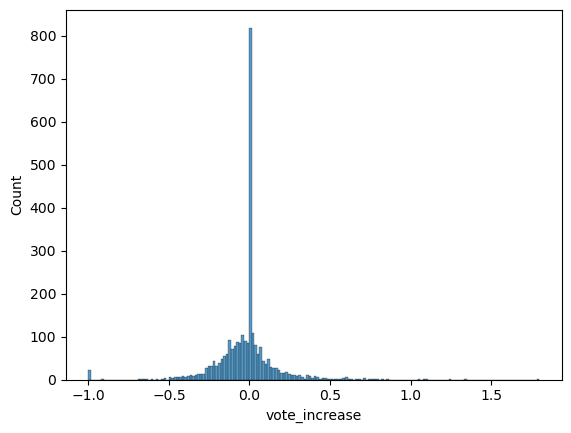

In [894]:
sns.histplot(df_insight["vote_increase"])

### แสดงจำนวน Word

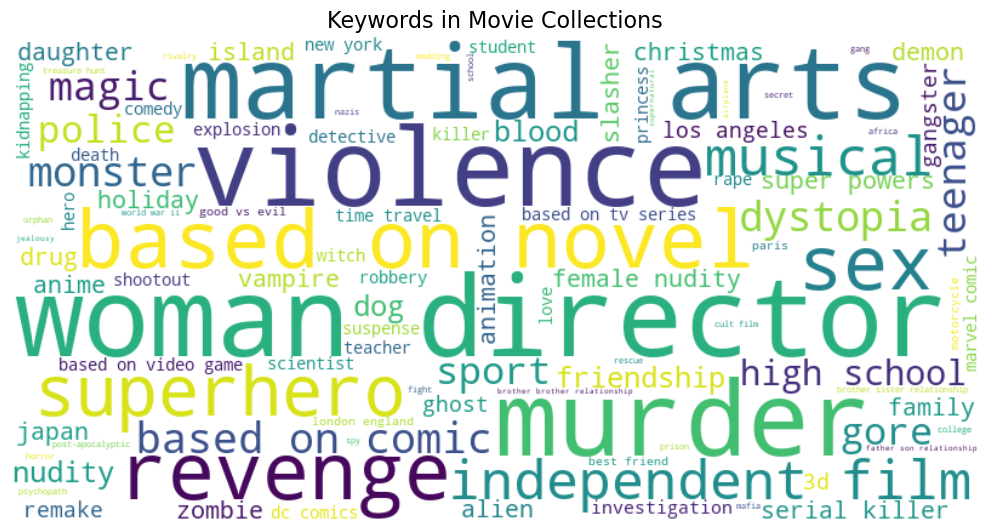

In [895]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
df_insight_pre = df_insight
# Filter to get one movie per collection
one_movie_per_collection = df_insight_pre.groupby('collection_name').first().reset_index()

# Extract all keywords from the filtered dataframe
all_keywords = []
for keywords in one_movie_per_collection['keywords'].dropna():
    if isinstance(keywords, list):
        all_keywords.extend(keywords)

# Count keyword frequencies
keyword_counts = Counter(all_keywords)

# Remove common sequel-related keywords if they exist
for keyword in ['sequel', 'duringcreditsstinger', 'aftercreditsstinger']:
    if keyword in keyword_counts:
        del keyword_counts[keyword]

# Create the word cloud
plt.figure(figsize=(10, 6))
if keyword_counts:  # Check if we have keywords to display
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1
    ).generate_from_frequencies(keyword_counts)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Keywords in Movie Collections', fontsize=16)
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "No keywords available for visualization", 
             horizontalalignment='center', fontsize=14)
    
plt.show()


### แสดงจำนวน genre

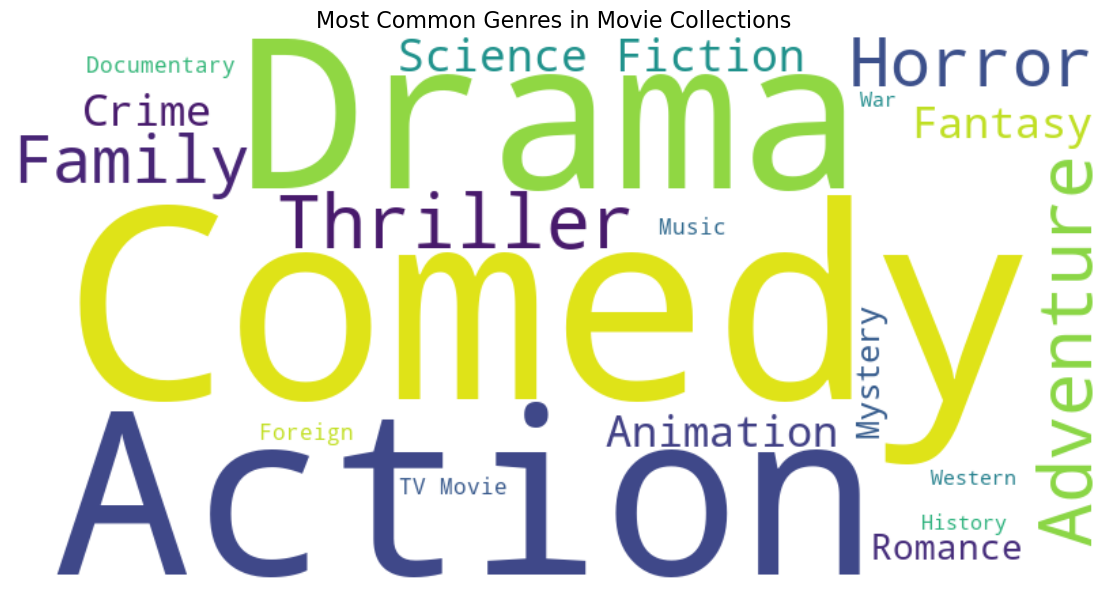

In [896]:
# Analyze most common genres in movie collections
all_genres = []
for genres in one_movie_per_collection['genres'].dropna():
    if isinstance(genres, list):
        all_genres.extend(genres)

# Count genre frequencies
genre_counts = Counter(all_genres)

# Create a word cloud for genres
plt.figure(figsize=(12, 6))
if genre_counts:
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=50,
        colormap='viridis',
        contour_width=1
    ).generate_from_frequencies(genre_counts)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Genres in Movie Collections', fontsize=16)
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "No genre data available for visualization", 
             horizontalalignment='center', fontsize=14)
plt.show()

## บันทึก

In [897]:
df_insight.to_csv("cleaned_6610401993.csv", encoding='utf8')
df_insight.to_pickle("cleaned_6610401993.pkl")